In [1]:
import torch
import clip

from cppn import CPPN, Sampler
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output, display
import time

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Init CLIP

In [3]:
model, preprocess = clip.load("ViT-B/32", device=device)

img_mean = torch.cuda.FloatTensor(preprocess.transforms[-1].mean).reshape(1, -1, 1, 1)
img_std = torch.cuda.FloatTensor(preprocess.transforms[-1].std).reshape(1, -1, 1, 1)

C:\Users\Heysoos\AppData\Local\Temp\ipykernel_10748\2906940543.py:3: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\tensor\python_tensor.cpp:80.)
  img_mean = torch.cuda.FloatTensor(preprocess.transforms[-1].mean).reshape(1, -1, 1, 1)


In [4]:
# text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)
# model.encode_text(text).shape

# Init CPPN

In [23]:
net_size = [512, 128, 128, 8]

num_nulls = 0
dim_in = 3 + num_nulls + 1 # 3 spatial coords + 4 null + z
dim_z = 16
dim_c = 3

# Fourier Features settings
proj_dims = [128]
proj_scales = [3 for i in proj_dims]
projection_config = (proj_dims, proj_scales)
print(net_size)

cppn = CPPN(
    net_size=net_size,
    dim_in=dim_in,
    dim_z=dim_z,
    dim_c=dim_c,
    projection_config=projection_config,
    use_fourier_features=False,
).cuda()

sampler = Sampler(cppn)

[512, 128, 128, 8]


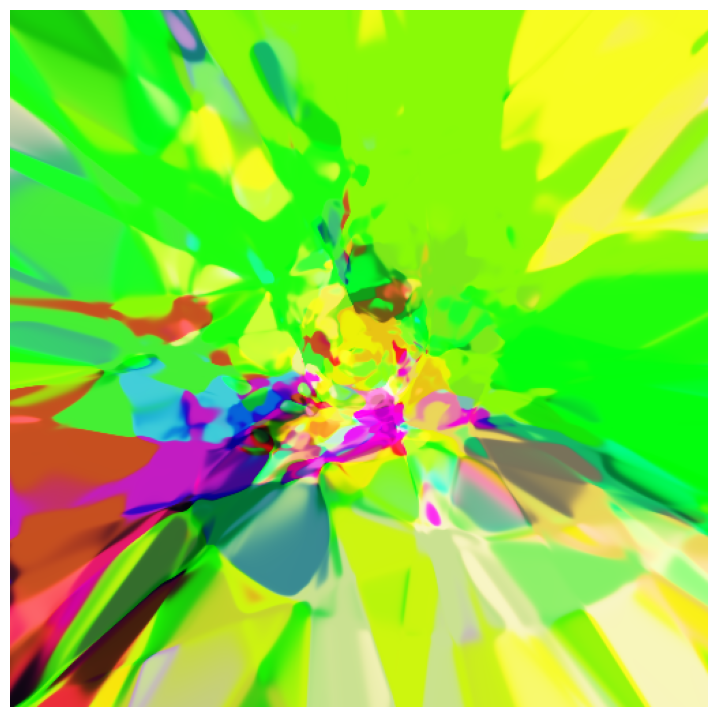

In [35]:
cppn.reinit()

scale = 3
z_scale = 1
xres = yres = 512
z = z_scale * torch.randn(1, dim_z).cuda()
coords = cppn._coordinates(scale, xres, yres, z, num_nulls=num_nulls)

x = sampler.generate_img(cppn, z, scale, xres, yres, coords)
sampler.imshow(x)

# Training

In [7]:
def make_loss(text):
    with torch.no_grad():
        text_features = model.encode_text(text)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    def clip_loss(image):
        # image = preprocess(image)
        image = torch.nn.functional.interpolate(image, size=224)
        image = (image - img_mean) / img_std
        
        image_features = model.encode_image(image)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        
        similarity = (image_features @ text_features.T).squeeze()
        return -similarity

    return clip_loss

# clip_loss = make_loss(text)

In [8]:
def plot_training(x, losses):
    plt.clf()
    # prepare images as (B, H, W, C)
    B = x.shape[0]
    x_vis = x.detach().cpu().reshape(B, xres, yres, -1)
    x_vis = x_vis.numpy()
    #choice = np.random.choice(B, size=B, replace=False)

    fig = plt.figure(figsize=(7, 7))
    gs = fig.add_gridspec(2, 4, height_ratios=[4, 1])

    num_rows = num_cols = int(np.sqrt(B))
    grid = gs[0, :].subgridspec(num_rows, num_cols, wspace=0.05, hspace=0.05)

    # 4x4 image grid
    axs_img = [fig.add_subplot(grid[r, c]) for r in range(num_rows) for c in range(num_cols)]
    for i, ax_img in enumerate(axs_img):
        #img = x_vis[choice[i]]
        img = x_vis[i]
        # normalize to [0, 1] per image for safe display
        vmin, vmax = img.min(), img.max()
        if vmax > 1.0 or vmin < 0.0:
            rng = (vmax - vmin) + 1e-8
            img = (img - vmin) / rng
        if img.shape[-1] == 1:
            ax_img.imshow(img[..., 0], cmap='gray', vmin=0.0, vmax=1.0)
        else:
            ax_img.imshow(np.clip(img, 0.0, 1.0))
        ax_img.axis('off')

    # full-width loss plot
    ax_loss = fig.add_subplot(gs[1, :])
    ax_loss.plot(-np.array(losses), color='tab:blue')
    ax_loss.set_title('Training loss')
    ax_loss.set_xlabel('Step')
    ax_loss.set_ylabel('Sim')
    ax_loss.grid(True, alpha=0.3)

    clear_output(wait=True)
    display(fig)
    time.sleep(0.001)
    plt.close(fig)

In [9]:
cppn.rule.amplitudes.requires_grad = False
cppn.rule.phases.requires_grad = False
cppn.rule.frequencies.requires_grad = False
cppn.rule.in_z.requires_grad = False

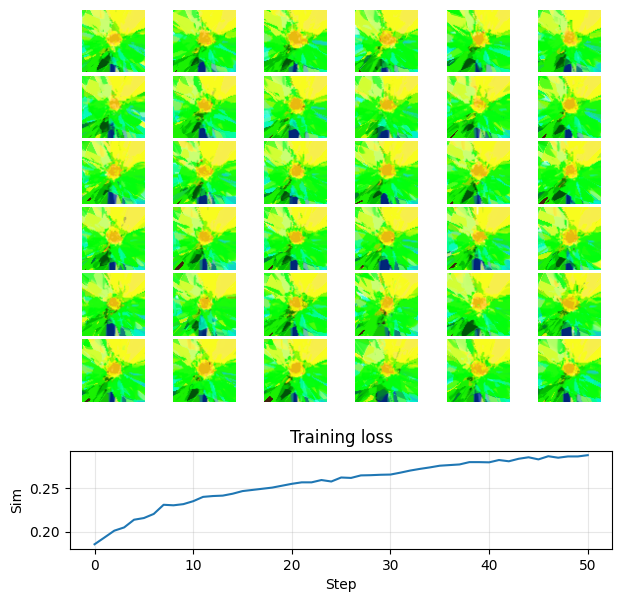

In [ ]:
batch_size = 36
lr = 1e-3
z_var = 0.2
coord_var = 0
goal = "a sunflower in the foreground and a blue sky in the background"
text = clip.tokenize([goal]).to(device)
xres = yres = 64

# fixed_z = z_scale * torch.randn(batch_size, dim_z).cuda()
fixed_z = z_scale * z.repeat(batch_size, 1)

coords = cppn._coordinates(scale, xres, yres, fixed_z, num_nulls=num_nulls, batch_size=batch_size)

optimizer = torch.optim.Adam(cppn.parameters(), lr=lr)
clip_loss = make_loss(text)

losses = []
for step in tqdm(range(1000)):
    optimizer.zero_grad()

    training_z = fixed_z + torch.randn(batch_size, dim_z).cuda() * z_var
    training_coords = [c + torch.randn_like(c) * coord_var for c in coords[:-1]] + [training_z.unsqueeze(1)]
    
    x = cppn.forward(training_coords)
    loss = clip_loss(x.reshape(batch_size, xres, yres, -1).permute(0, 3, 1, 2)).mean()
    # print(f'step {step}, loss {loss.item()}')
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    if step % 25 == 0:
        plot_training(x, losses)

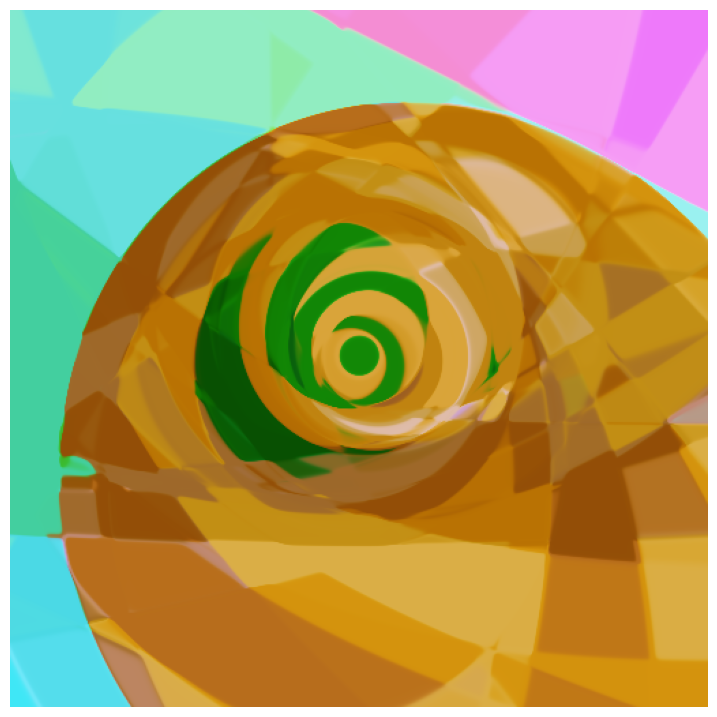

In [34]:
with torch.no_grad():
    coords = cppn._coordinates(scale, 512, 512, training_z[0:1], num_nulls=num_nulls)
    
    x = cppn.forward(coords).reshape(512, 512, -1)
    sampler.imshow(x.cpu().numpy())

In [12]:
x.shape

torch.Size([512, 512, 3])

In [13]:
imgs = x.reshape(batch_size, xres, yres, -1).detach().cpu().numpy()

fig, axes = plt.subplots(2, 2)

for i, ax in enumerate(axes.flatten()):
    ax.imshow(imgs[i])

RuntimeError: shape '[4, 160, 160, -1]' is invalid for input of size 786432